In [1]:
    !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    !pip install lightning pytorch-lightning==1.9.5
    !pip install -U albumentations
    !pip install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git
    !pip install timm!pip install timm
    !pip install openslide-python
    !pip install scikit-learn
    !pip install seaborn matplotlib

Looking in indexes: https://download.pytorch.org/whl/cu118
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 38.0 MB/s eta 0:00:00
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 2.4.0
    Uninstalling pytorch-lightning-2.4.0:
      Successfully uninstalled pytorch-lightning-2.4.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.9/227.9 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.2/303.2 kB 17.8 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.17
    Uninstalling albucore-0.0.17:
      Successfully uninstalled albucore-0.0.17
  Attempting unin

In [2]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


In [3]:
import pandas as pd
import numpy as np
import os
import ast
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning import Trainer

# ****Eliminar Inconsistencias****

In [4]:
import pandas as pd
import ast

df = pd.read_csv('/kaggle/input/full_df.csv')
df.head(30)

df['labels'] = df['labels'].apply(lambda x: ast.literal_eval(x)[0] if isinstance(x, str) else x)

def find_inconsistencies(df):
    inconsistencies = []


    diagnosis_map = {0: 'N', 1: 'D', 2: 'G', 3: 'C', 4: 'A', 5: 'H', 6: 'M', 7: 'O'}

    for idx, row in df.iterrows():
        diagnosis_values = [row['N'], row['D'], row['G'], row['C'], row['A'], row['H'], row['M'], row['O']]
        active_diagnosis = [diagnosis_map[i] for i, val in enumerate(diagnosis_values) if val == 1]
        expected_label = active_diagnosis[0] if len(active_diagnosis) == 1 else '+'.join(active_diagnosis)

        if row['labels'] != expected_label:
            inconsistencies.append({
                'ID': row['ID'],
                'Label Esperado': expected_label,
                'Label Actual': row['labels'],
                'N': row['N'], 'D': row['D'], 'G': row['G'], 'C': row['C'],
                'A': row['A'], 'H': row['H'], 'M': row['M'], 'O': row['O']
            })

    inconsistency_df = pd.DataFrame(inconsistencies)
    return inconsistency_df

inconsistencies = find_inconsistencies(df)
inconsistencies.head(10)


def remove_significant_inconsistencies(df):
    rows_to_remove = []
    removed_rows_info = []

    diagnosis_map = {0: 'N', 1: 'D', 2: 'G', 3: 'C', 4: 'A', 5: 'H', 6: 'M', 7: 'O'}

    for idx, row in df.iterrows():
        diagnosis_values = [row['N'], row['D'], row['G'], row['C'], row['A'], row['H'], row['M'], row['O']]
        active_diagnosis = [diagnosis_map[i] for i, val in enumerate(diagnosis_values) if val == 1]
        expected_label = active_diagnosis[0] if len(active_diagnosis) == 1 else '+'.join(active_diagnosis)

        if not any(char in expected_label for char in row['labels']):
            rows_to_remove.append(idx)
            removed_rows_info.append({
                'ID': row['ID'],
                'Label Esperado': expected_label,
                'Label Actual': row['labels'],
                'N': row['N'], 'D': row['D'], 'G': row['G'], 'C': row['C'],
                'A': row['A'], 'H': row['H'], 'M': row['M'], 'O': row['O']
            })

    removed_df = pd.DataFrame(removed_rows_info)
    df_cleaned = df.drop(index=rows_to_remove)

    return df_cleaned, removed_df


df_cleaned, removed_rows = remove_significant_inconsistencies(df)
removed_rows.head(10)
df_cleaned.head(30)


,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg
5,6,60,Male,6_left.jpg,6_right.jpg,macular epiretinal membrane,moderate non proliferative retinopathy，epireti...,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",6_right.jpg
6,7,60,Female,7_left.jpg,7_right.jpg,drusen,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",7_right.jpg
7,8,59,Male,8_left.jpg,8_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",8_right.jpg
8,9,54,Male,9_left.jpg,9_right.jpg,normal fundus,vitreous degeneration,0,0,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,O,"[0, 0, 0, 0, 0, 0, 0, 1]",9_right.jpg
10,11,60,Female,11_left.jpg,11_right.jpg,moderate non proliferative retinopathy，hyperte...,moderate non proliferative retinopathy，hyperte...,0,1,0,0,0,1,0,0,../input/ocular-disease-recognition-odir5k/ODI...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",11_right.jpg
11,13,60,Female,13_left.jpg,13_right.jpg,pathological myopia,pathological myopia,0,0,0,0,0,0,1,0,../input/ocular-disease-recognition-odir5k/ODI...,M,"[0, 0, 0, 0, 0, 0, 1, 0]",13_right.jpg


# **Definimos el dataset personalizado**

In [5]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from albumentations import Compose, Normalize, Resize
from albumentations.pytorch import ToTensorV2

IMG_SIZE = 224  
BATCH_SIZE = 128  
EPOCHS = 50 

transform = Compose([
    Resize(IMG_SIZE, IMG_SIZE),
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

class OcularDataset(Dataset):
    def __init__(self, df, image_path, label_map, transform=None):
        self.df = df
        self.image_path = image_path
        self.label_map = label_map
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_path, row['filename'])
        img = cv2.imread(img_path)

        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        else:
            img = np.zeros((IMG_SIZE, IMG_SIZE, 3))  # Imagen negra en caso de error

        if self.transform:
            img = self.transform(image=img)["image"]

        label = self.label_map[row['labels']]
        return img, label


# **Balanceamos el dataset**

In [6]:
from sklearn.utils import resample
from albumentations import HorizontalFlip, RandomBrightnessContrast, ShiftScaleRotate
from albumentations import (
    HorizontalFlip, VerticalFlip, RandomBrightnessContrast, ShiftScaleRotate, 
    RandomResizedCrop, ColorJitter, Normalize, Compose
)
from albumentations.pytorch import ToTensorV2

class_dfs = {label: df_cleaned[df_cleaned['labels'] == label] for label in df_cleaned['labels'].unique()}

target_count = 1200

preprocessed_image_path = '/kaggle/input/preprocessed_images/'

train_transform = Compose([
    RandomResizedCrop(height=IMG_SIZE, width=IMG_SIZE, scale=(0.7, 1.0), ratio=(0.75, 1.333), p=1.0),
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.2),  # Agregar Flip Vertical ocasional
    ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=20, p=0.7),  # Rotaciones y escalas más amplias
    RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),  # Más variabilidad en brillo/contraste
    ColorJitter(p=0.3),  # Simular cambios de color/iluminación
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])


test_transform = Compose([
    Resize(IMG_SIZE, IMG_SIZE),
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

balanced_dfs = []
for label, class_df in class_dfs.items():
    if len(class_df) > target_count:  
        balanced_dfs.append(class_df.sample(n=target_count, random_state=42))
    elif len(class_df) < target_count:  
        augmented_samples = []
        for _, row in class_df.iterrows():
            img_path = os.path.join(preprocessed_image_path, row['filename'])
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            while len(augmented_samples) + len(class_df) < target_count:
                aug_img = train_transform(image=img)["image"].numpy()
                augmented_samples.append({
                    'filename': row['filename'],  # Copiar información del archivo original
                    'labels': label
                })

       
        augmented_df = pd.DataFrame(augmented_samples)
        balanced_dfs.append(pd.concat([class_df, augmented_df]))
    else:
        balanced_dfs.append(class_df)


balanced_df = pd.concat(balanced_dfs).reset_index(drop=True)


print("Nueva distribución de etiquetas:")
print(balanced_df['labels'].value_counts())

Nueva distribución de etiquetas:
labels
N    1200
D    1200
O    1200
M    1200
H    1200
C    1200
A    1200
G    1200
Name: count, dtype: int64


# **Realizamos las divisiones**

In [7]:
from sklearn.model_selection import train_test_split

label_map = {label: idx for idx, label in enumerate(balanced_df['labels'].unique())}

train_df, test_df = train_test_split(balanced_df, test_size=0.2, random_state=42)

preprocessed_image_path = '/kaggle/input/preprocessed_images/'

train_dataset = OcularDataset(train_df, preprocessed_image_path, label_map, transform=train_transform)
test_dataset = OcularDataset(test_df, preprocessed_image_path, label_map, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# **Definimos el modelo**

In [8]:
from torchvision.models import densenet121
import torch.nn as nn
import torch

class OcularDenseNet(nn.Module):
    def __init__(self, num_classes):
        super(OcularDenseNet, self).__init__()
        self.base_model = densenet121(weights="IMAGENET1K_V1")  # Modelo preentrenado
        in_features = self.base_model.classifier.in_features  # Tamaño de la última capa FC
        
        # Añadir Dropout y capa personalizada
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(0.7),  # Dropout para evitar sobreajuste
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = OcularDenseNet(num_classes=len(label_map)).to(device)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 209MB/s]


# **Ajustamos optimizadores**

In [9]:
from torch.amp import GradScaler, autocast

scaler = GradScaler()
criterion = nn.CrossEntropyLoss()


# **Iniciamos el entrenamiento**

In [10]:
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.amp import GradScaler, autocast

BASE_LR = 0.000009
optimizer = optim.AdamW(model.parameters(), lr=BASE_LR, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=6, verbose=True)

class_counts = balanced_df['labels'].value_counts().sort_index().values

class_weights = torch.tensor([1.0 / count for count in class_counts], dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)

scaler = GradScaler()

train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        
        with autocast(device_type="cuda"):
            outputs = model(images)
            loss = criterion(outputs, labels)

        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            with autocast(device_type="cuda"):
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

    val_loss /= len(test_loader)
    val_losses.append(val_loss)
    val_accuracy = correct / total

    
    scheduler.step(val_loss)

    
    print(f"Epoch {epoch + 1}/{EPOCHS} | Training Loss: {train_loss:.4f} | Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f}")


Epoch 1/50 | Training Loss: 2.0405 | Validation Loss: 1.2617 | Validation Accuracy: 0.6880
Epoch 2/50 | Training Loss: 1.4775 | Validation Loss: 0.8994 | Validation Accuracy: 0.7198
Epoch 3/50 | Training Loss: 1.1478 | Validation Loss: 0.7771 | Validation Accuracy: 0.7339
Epoch 4/50 | Training Loss: 0.9965 | Validation Loss: 0.7174 | Validation Accuracy: 0.7422
Epoch 5/50 | Training Loss: 0.9058 | Validation Loss: 0.6833 | Validation Accuracy: 0.7495
Epoch 6/50 | Training Loss: 0.8425 | Validation Loss: 0.6602 | Validation Accuracy: 0.7568
Epoch 7/50 | Training Loss: 0.7936 | Validation Loss: 0.6424 | Validation Accuracy: 0.7620
Epoch 8/50 | Training Loss: 0.7696 | Validation Loss: 0.6299 | Validation Accuracy: 0.7635
Epoch 9/50 | Training Loss: 0.7491 | Validation Loss: 0.6174 | Validation Accuracy: 0.7682
Epoch 10/50 | Training Loss: 0.7312 | Validation Loss: 0.6060 | Validation Accuracy: 0.7688
Epoch 11/50 | Training Loss: 0.7191 | Validation Loss: 0.5982 | Validation Accuracy: 0.77

# **Resultados**

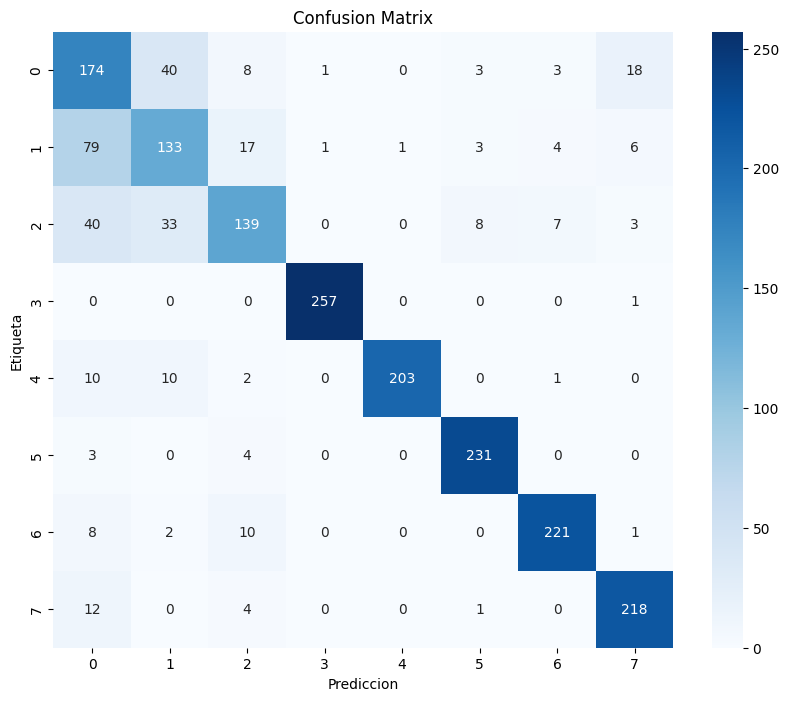

Classification Report:
              precision    recall  f1-score   support

           N       0.53      0.70      0.61       247
           D       0.61      0.55      0.58       244
           O       0.76      0.60      0.67       230
           M       0.99      1.00      0.99       258
           H       1.00      0.90      0.94       226
           C       0.94      0.97      0.95       238
           A       0.94      0.91      0.92       242
           G       0.88      0.93      0.90       235

    accuracy                           0.82      1920
   macro avg       0.83      0.82      0.82      1920
weighted avg       0.83      0.82      0.82      1920



In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(predictions, labels, num_classes):
    cm = confusion_matrix(labels, predictions, labels=list(range(num_classes)))
    plt.figure(figsize=(10, 8))  
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(range(num_classes)), yticklabels=list(range(num_classes)))
    plt.title('Confusion Matrix')
    plt.xlabel('Prediccion')
    plt.ylabel('Etiqueta')
    plt.show()  


model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


plot_confusion_matrix(all_preds, all_labels, num_classes=len(label_map))


print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=[str(label) for label in label_map.keys()], zero_division=1))


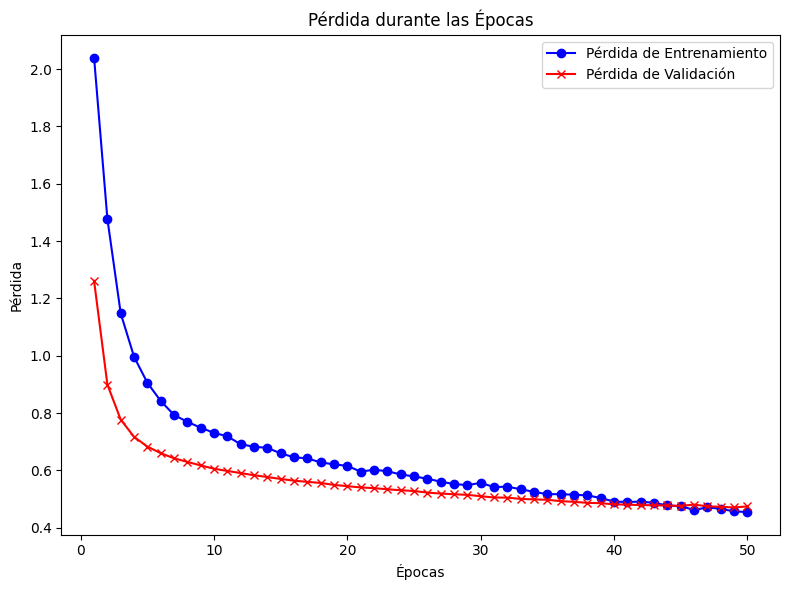

Precision: 0.8296
Recall: 0.8208
F1 Score: 0.8221


In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

plt.figure(figsize=(8, 6))
plt.plot(range(1, EPOCHS + 1), train_losses, label='Pérdida de Entrenamiento', color='blue', linestyle='-', marker='o')
plt.plot(range(1, EPOCHS + 1), val_losses, label='Pérdida de Validación', color='red', linestyle='-', marker='x')
plt.title('Pérdida durante las Épocas')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.tight_layout()
plt.show()

precision = precision_score(all_labels, all_preds, average='weighted', zero_division=1)
recall = recall_score(all_labels, all_preds, average='weighted', zero_division=1)
f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=1)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
